In [1]:
import numpy as np
from astropy.modeling.blackbody import blackbody_lambda
from astropy import units as u
from astropy import constants as const
import simmetis as sim
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Number of photons on the detector

In [2]:
cmd = sim.UserCommands("metis_image_NQ.config")
cmd["OBS_EXPTIME"]=1
cmd["ATMO_USE_ATMO_BG"] = "yes"
cmd["SCOPE_USE_MIRROR_BG"] = "yes"
cmd["SIM_VERBOSE"]="no"
cmd["FPA_QE"]="TC_detector_METIS_NQ_no_losses.dat"
metis_filter_id="Q1"
cmd["INST_FILTER_TC"]="TC_filter_" + metis_filter_id + ".dat"

In [3]:
opt = sim.OpticalTrain(cmd)

In [4]:
fpa = sim.Detector(cmd, small_fov=False)

In [18]:
## generate a source with 0 mag
lam, spec = sim.source.flat_spectrum(-100, "TC_filter_" + metis_filter_id + ".dat")
src = sim.Source(lam=lam, spectra=np.array([spec]), 
                 ref=[0], x=[0], y=[0])
src_chopped = sim.Source(lam=lam, spectra=np.array([spec]), 
                 ref=[0], x=[0], y=[1])

#### Compute number of background photons in SimMETIS simulated image

In [19]:
src.apply_optical_train(opt, fpa)
exptime=1
photonflux = fpa.chips[0].array.T
clean_image = photonflux * exptime ## noise free image before applying Poisson noise

hdu = fpa.read_out(OBS_EXPTIME=1) # image including Poisson noise
src_chopped.apply_optical_train(opt,fpa) # the same for the chopped position
hdu_chopped = fpa.read_out(OBS_EXPTIME=1) # the same for the chopped position

Generating image for chip 1
Reading out chip 1 using superfast
1.27798245732e+13 12187790.4636 12187790.4636 12187790.4636
1.27798e+13 1.21714e+07 1.22041e+07 1.21878e+07
Generating image for chip 1
Reading out chip 1 using superfast
1.27798245732e+13 12187790.4636 12187790.4636 12187790.4636
1.27798e+13 1.217e+07 1.22048e+07 1.21878e+07


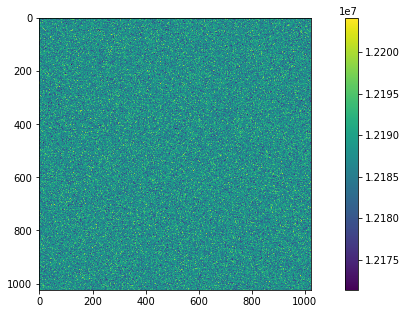

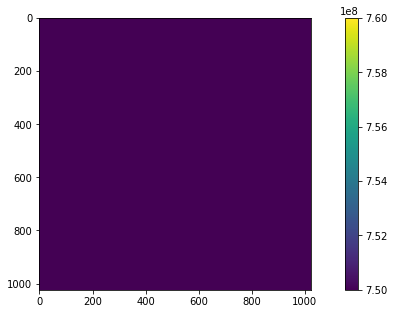

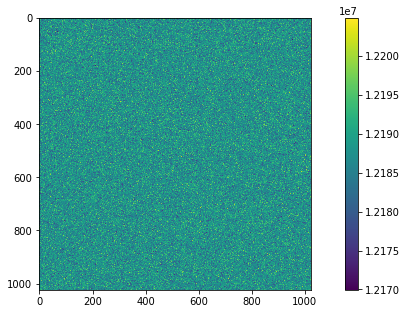

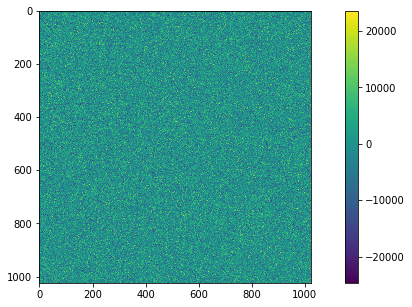

In [20]:
##
## chop A frame
plt.figure(figsize=(12,5))
#plt.imshow(hdu[0].data, interpolation="none", vmin=7.6e8,vmax=7.6e8)
plt.imshow(hdu[0].data, interpolation="none")
plt.colorbar()
##
## chop A frame without noise
plt.figure(figsize=(12,5))
plt.imshow(clean_image, interpolation="none", vmin=7.5e8,vmax=7.6e8)
plt.colorbar()
##
## chop B frame
plt.figure(figsize=(12,5))
plt.imshow(hdu_chopped[0].data, interpolation="none")
plt.colorbar()
##
## chop difference A-B frame
plt.figure(figsize=(12,5))
plt.imshow(hdu_chopped[0].data-hdu[0].data, interpolation="none")
plt.colorbar()

In [30]:
np.std(clean_image[200:400,200:400])

325.47114481861274

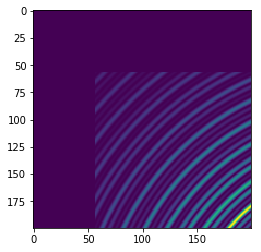

In [31]:
plt.imshow(clean_image[200:400,200:400])

In [32]:
np.std(hdu[0].data[200:400,200:400])

23551.757248793325

In [33]:
bgphotons_per_pix=np.median(hdu[0].data)
#bgphotons_per_pix*=1.1 ## takes into account bg photons from entrance window, not included in the simulation so far
print("The number of bg counts per second per pix is {0:.2E}".format(bgphotons_per_pix))
## Note that this is identical with bg photons if detector QE is 1 (as in TC_detector_METIS_NQ_no_losses.dat)

The number of bg counts per second per pix is 5.54E+08


This number can be compared with 5.5e8 from Roy's doc (N2/median, Table 4, version 0.8).

## ELFN

In [34]:
# from Roy; works on chop-difference frame (?)
from  scipy.interpolate import interp1d
def ELFN_penalty(photonflux):
    x=[0, 2e8, 8e8,10e8,25e8] # [ph/s/pix]
    y=[1,1.37,3.38,3.64,4.65] # ELFN noise penalty factor
    penalty_interp=interp1d(x,y)
    penalty=penalty_interp(photonflux)[()]
    return(penalty)

In [35]:
noise = hdu[0].data - clean_image
elfn_image = clean_image + ELFN_penalty(photonflux)*noise
print(np.median(elfn_image[200:400,200:400]))
print(np.std(elfn_image[200:400,200:400]))

554092954.19
60199.6254559


## Source photons

In [36]:
source_bgsubtracted = np.sum(clean_image-np.median(clean_image))
print("Bg-subtracted source photons (per s): {0:.2E}".format(source_bgsubtracted))

Bg-subtracted source photons (per s): 1.83E+10


In [37]:
# this matches with the expected flux from Roy which is 1.89e10

In [71]:
## background counts/s
print(np.min(clean_image))

554092490.668


### Compare to the number of photons to expect

In [ ]:
# check sim.source.photons_to_mag

In [ ]:
# source of 0.8 mag corresponds to 14.4 Jy in N2 according to Roy
from astropy import units as u
from astropy import constants as c
F = 14.4 * u.Jy
lam1=10.12*u.micron
lam2=13.13*u.micron
nu1 = c.c/lam1
nu2 = c.c/lam2
bandwidth_nu = - (nu2-nu1)

In [ ]:
e_ph = c.h*(0.5*(nu2+nu1))
N_ph = (F * 1*u.s * area_ELT * bandwidth_nu / e_ph).decompose()
N_ph # without transmission losses

In [ ]:
# including transmission losses -- it matches with the numbers above (30 Aug 2018)
## 0.36: total system transmission ELT+METIS of N2 filter / without atmospheric losses
## 0.6: detector QE (not included here for the time being)
N_ph * 0.36

### Other tests

In [ ]:
# The transmission curve used (tc_source includes atmosphere; tc_atmo, despite its name, doesn't)
plt.plot(opt.tc_source.lam,opt.tc_source,label="total transmission")
plt.plot(opt.tc_atmo.lam,opt.tc_atmo, label="transmission without atmosphere")
plt.legend()

In [ ]:
# atmosphe
from scipy.ndimage.filters import gaussian_filter
plt.plot(opt.ph_atmo.lam,gaussian_filter(opt.ph_atmo,sigma=3))
plt.ylim([0,1e6])
plt.xlim([10,13])